# Import libraries, load and transform data

In [1]:
!pip install -q evaluate transformers datasets mlflow

In [2]:
# imports
import warnings 
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

15000 15000


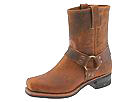

In [3]:
# use https://huggingface.co/docs/datasets/image_load for reference

image_dict = {}
# Define the list of file names
from pathlib import Path
from tqdm import tqdm
file_names = []
labels = []
for file in sorted((Path('/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/').glob('*/*.jpg'))):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [4]:
labels[:5]

['Boot', 'Boot', 'Boot', 'Boot', 'Boot']

In [5]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Sandal', 1: 'Boot', 2: 'Shoe'} 

 {'Sandal': 0, 'Boot': 1, 'Shoe': 2}


In [6]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 15000
})

In [7]:
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset['train']
test_data = dataset['test']

In [8]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [9]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [11]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800963


In [12]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [13]:
metric_name = "accuracy"
model_name = "footwear_image_detection"
num_train_epochs=10
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [15]:
trainer.evaluate()

{'eval_loss': 1.129163384437561,
 'eval_accuracy': 0.18466666666666667,
 'eval_runtime': 40.7422,
 'eval_samples_per_second': 73.634,
 'eval_steps_per_second': 9.204}

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.098570,0.988000
2,0.291300,0.061889,0.991000
3,0.045000,0.055726,0.988333
4,0.026400,0.047089,0.991000
5,0.026400,0.046225,0.990333
6,0.020200,0.043175,0.991333
7,0.013700,0.043812,0.990333
8,0.011300,0.041177,0.990333
9,0.011300,0.042077,0.990667
10,0.009200,0.040555,0.990667


TrainOutput(global_step=3750, training_loss=0.05618902225494385, metrics={'train_runtime': 2961.2795, 'train_samples_per_second': 40.523, 'train_steps_per_second': 1.266, 'total_flos': 9.29912209809408e+18, 'train_loss': 0.05618902225494385, 'epoch': 10.0})

In [17]:
trainer.evaluate()

{'eval_loss': 0.04055546224117279,
 'eval_accuracy': 0.9906666666666667,
 'eval_runtime': 26.9261,
 'eval_samples_per_second': 111.416,
 'eval_steps_per_second': 13.927,
 'epoch': 10.0}

In [18]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.04055546224117279, 'test_accuracy': 0.9906666666666667, 'test_runtime': 27.0855, 'test_samples_per_second': 110.76, 'test_steps_per_second': 13.845}


Accuracy: 0.9907
F1 Score: 0.9907


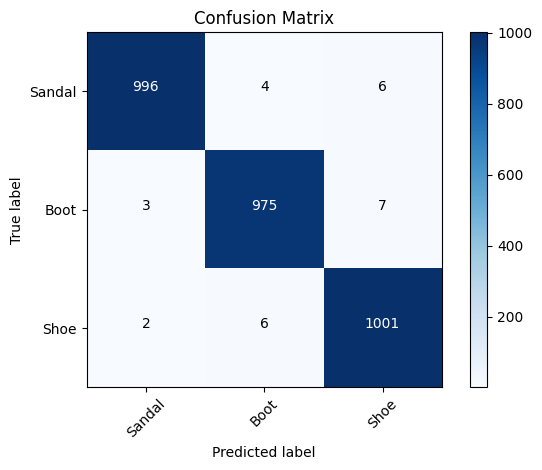

In [19]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    
    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)

In [20]:
trainer.save_model()

In [21]:
from transformers import pipeline

pipe = pipeline('image-classification',model=model_name,device=0)

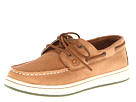

In [22]:
image = test_data[1]["image"]

image

In [23]:
pipe(image)

[{'score': 0.991980791091919, 'label': 'Shoe'},
 {'score': 0.004222146235406399, 'label': 'Boot'},
 {'score': 0.003797028446570039, 'label': 'Sandal'}]

In [24]:
# actual label
test_data[1]["label"]

'Shoe'

# Send model to Huggingface

In [25]:
# finally, save the model to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [26]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"dima806/{model_name}"
try:
    api.create_repo(repo_id)
    print(f"Repo {repo_id} created")
except:
    print(f"Repo {repo_id} already exists")

Repo dima806/footwear_image_detection created


In [27]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)

optimizer.pt:   0%|          | 0.00/687M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/627 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/dima806/footwear_image_detection/tree/main/.'